# Segmentation of Indian Traffic

In [4]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,BatchNormalization, ReLU, Reshape
#from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, CuDNNLSTM, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
import random as rn

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
  paths = [list(),list()]
  data_files = os.listdir(root_dir)
  for i,sub_file in enumerate(data_files):
    sub_file_path = root_dir + '/' + sub_file + '/'
    folder = os.listdir(sub_file_path)
    for folder_name in folder:
      path_name_folder_name = root_dir + '/' + sub_file + '/' + folder_name + '/'
      files = os.listdir(path_name_folder_name)
      for file in files:
        if (file.endswith("jpg")):
          path_name = root_dir + '/' + sub_file + '/' + folder_name + '/' + file
          path_name = str(path_name)
          paths[i].append(path_name)

        if (file.endswith("json")):
          path_name = root_dir + '/' + sub_file + '/' + folder_name + '/' + file
          path_name = str(path_name)
          paths[i].append(path_name)

  # intialise data of lists. 
  data = {'image':paths[0], 
        'json':paths[1]} 
  
  # Create DataFrame 
  data_df = pd.DataFrame(data) 
       
  return data_df

In [ ]:
root_dir = 'data'
data_df = return_file_names_df(root_dir)
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


In [ ]:
import json 
  
# Opening JSON file 
f = open('data/mask/201/frame0029_gtFine_polygons.json',) 
  
# returns JSON object as  
# a dictionary 
data = json.load(f) 
  
# Iterating through the json 
# list
labels = [] 
for i in data['objects']: 
  #print(i['label'])
  labels.append(i['label']) 

  
# Closing file 
f.close()

In [ ]:
print(len(list(set(labels))))

18


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:

def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:

def return_unique_labels(data_df):
  unique_labels = dict()
  for i , row in data_df.iterrows():
    # Opening JSON file 
    f = open(row['json'],) 
    data = json.load(f)
    labels = [] 
    for i in data['objects']:
      labels.append(i['label']) 

    labels = list(set(labels))  

    for label in labels:
      unique_labels[label] = unique_labels.get(label, 0) + 1
      #if label not in unique_labels:
        #unique_labels[label] += 1
  return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

In [ ]:
unique_labels

{'animal': 341,
 'autorickshaw': 2035,
 'bicycle': 321,
 'billboard': 2509,
 'bridge': 387,
 'building': 3136,
 'bus': 914,
 'car': 2981,
 'caravan': 53,
 'curb': 2447,
 'drivable fallback': 3616,
 'ego vehicle': 2,
 'fallback background': 893,
 'fence': 1024,
 'ground': 2,
 'guard rail': 728,
 'motorcycle': 2955,
 'non-drivable fallback': 2931,
 'obs-str-bar-fallback': 3972,
 'out of roi': 127,
 'parking': 17,
 'person': 2422,
 'pole': 3866,
 'polegroup': 337,
 'rail track': 4,
 'rectification border': 3,
 'rider': 2825,
 'road': 3861,
 'sidewalk': 617,
 'sky': 3991,
 'traffic light': 167,
 'traffic sign': 1728,
 'trailer': 6,
 'train': 4,
 'truck': 2090,
 'tunnel': 5,
 'unlabeled': 2,
 'vegetation': 3984,
 'vehicle fallback': 2459,
 'wall': 2180}

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [5]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [6]:
class_label = [i for i in label_clr.values()]
class_label = list(set(class_label))
class_label = sorted(class_label)
class_label

[0,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200]

In [7]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(label_clr)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
file = 'data/mask/201/frame0029_gtFine_polygons.json'
def get_poly(file):
  f = open(file,)
  data = json.load(f) 
  h = data['imgHeight']
  w = data['imgWidth']
  label = []
  vertexlist = []
  for i in data['objects']:
    label.append(i['label']) 
    polygon = i['polygon']
    polygon = [tuple(i) for i in polygon]
    vertexlist.append(polygon)


  return w, h, label, vertexlist  

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

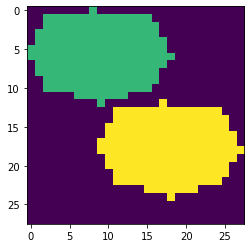

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
file = 'data/mask/201/frame0029_gtFine_polygons.json'
w, h, labels, vertexlist = get_poly(file)

In [ ]:
def compute_masks(data_df):
  mask = []
  for i , row in data_df.iterrows():
    file = row['json']
    file1 = row['image']
    w, h, labels, vertexlist = get_poly(file)

    s = file1
    s = s.split('/')
    s = [i.split('.') for i in s]
    
    path = s[0][0] + '/' + 'output' + '/' + s[2][0] + '/' +s[3][0] + '.jpg'
    path = str(path)

    img = Image.new("RGB", (w, h))
    img1 = ImageDraw.Draw(img)
    found = 0
    for i in range(len(vertexlist)):
      if len(vertexlist[i]) == 0:
        found = 1

    if found == 0:
      for i in range(len(vertexlist)):
        img1.polygon(vertexlist[i], fill = label_clr[labels[i]])
      img=np.array(img)
      im = Image.fromarray(img[:,:,0])
      mask.append(path)
      im.save(path)
    else:
      mask.append('Nan')

  data_df['mask'] = mask
    
  return data_df

In [ ]:
data_df = compute_masks(data_df)

In [ ]:
data_df.to_csv('preprocessed_data.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt


True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


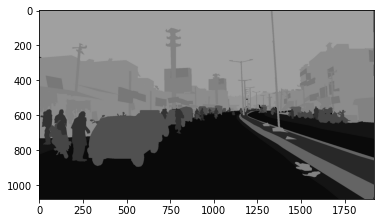

In [ ]:
# i  created two dataframe one with .png format and another with .jpg file because .png file is not 
# supported in further down data pipeline.
import urllib.request
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data4/output/201/frame0029_gtFine_polygons.png')    
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

In [ ]:
import pandas as pd
df = pd.read_csv('preprocessed_data.csv')

In [ ]:
d = df[(df['mask'] != 'Nan')]
d.shape


(4001, 3)

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

In [ ]:
file_name = []
for i , row in d.iterrows():
  f = []
  s = row['image']
  t = row['mask']
  #s = s.split('/')
  #s = [i.split('.') for i in s]
  f.append(s)
  f.append(t)
  file_name.append(f)



In [ ]:
len(file_name)

4001

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(list(file_name), test_size=0.15, random_state=42)

In [ ]:
!pip install -U --pre segmentation-models

     |████████████████████████████████| 51kB 4.3MB/s 


In [ ]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', encoder_freeze = True, input_shape=(512,512,3))

85524480/85521592 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [ ]:
import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
class Dataset:
    def __init__(self, file_names, classes , types):
        
        self.ids = file_names
        self.class_ids = classes
        self.types = types
        self.images_fps   = [image_id[0] for image_id in self.ids]
        self.masks_fps    = [image_id[1] for image_id in self.ids]
       

    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = np.float32(cv2.resize(image, (512, 512)))

        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = mask
   

        image_masks = [(image_mask == i) for i  in self.class_ids]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        image_mask = np.float32(cv2.resize(image_mask, (512, 512)))
        

        if self.types == 'train':
          a = np.random.uniform()
          if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
          elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
          elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
          elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
          else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)

            
          return image, image_mask

        else:
          
          return image, image_mask

        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# https://github.com/qubvel/segmentation_models
#import segmentation_models as sm
from segmentation_models.metrics import iou_score



rms = tf.keras.optimizers.RMSprop(learning_rate=0.001)

focal_loss = sm.losses.cce_dice_loss

model.compile(rms, focal_loss, metrics=[iou_score])

In [ ]:
#CLASSES = CLASSES
train_dataset = Dataset(X_train, classes=class_label , types ='train')
test_dataset  = Dataset(X_test, classes=class_label, types = 'test')

train_dataloader = Dataloder(train_dataset, batch_size=5, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=5, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (5, 512, 512, 3)
assert train_dataloader[0][1].shape == (5, 512, 512, 21)

(5, 512, 512, 3)


In [ ]:
(train_dataloader[0][0].shape) , (train_dataloader[0][1].shape)

((5, 512, 512, 3), (5, 512, 512, 21))

In [ ]:
(test_dataloader[0][0].shape) , (test_dataloader[0][1].shape)

((5, 512, 512, 3), (5, 512, 512, 21))

In [ ]:
callbacks_ = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score')]

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader)//5, epochs=70,\
                              validation_data=test_dataloader,validation_steps =len(test_dataloader)//5,callbacks=callbacks_ )


Epoch 1/70
136/136 [==============================] - 1277s 9s/step - loss: 0.9502 - iou_score: 0.0928 - val_loss: 1.0563 - val_iou_score: 0.0939
Epoch 2/70
136/136 [==============================] - 713s 5s/step - loss: 0.8116 - iou_score: 0.1841 - val_loss: 0.8965 - val_iou_score: 0.1386
Epoch 3/70
136/136 [==============================] - 625s 5s/step - loss: 0.7488 - iou_score: 0.2300 - val_loss: 0.8317 - val_iou_score: 0.1837
Epoch 4/70
136/136 [==============================] - 608s 4s/step - loss: 0.7204 - iou_score: 0.2569 - val_loss: 0.7799 - val_iou_score: 0.2259
Epoch 5/70
136/136 [==============================] - 568s 4s/step - loss: 0.6035 - iou_score: 0.3684 - val_loss: 0.5956 - val_iou_score: 0.3743
Epoch 6/70
136/136 [==============================] - 568s 4s/step - loss: 0.5926 - iou_score: 0.3792 - val_loss: 0.5894 - val_iou_score: 0.3812
Epoch 7/70
136/136 [==============================] - 517s 4s/step - loss: 0.5836 - iou_score: 0.3844 - val_loss: 0.5485 - val_io

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

In [ ]:
ls

 best_model1.h5                       data5/
 best_model2.h5                       data6/
 best_model.h5                        data.zip
'Copy of Reference_Pipelines.ipynb'   preprocessed_data1.csv
 data/                                preprocessed_data.csv
 data1/                               Reference_Preptrained_Unet.ipynb
 data2/                               Segmentation_Assignment.ipynb
 data3/                               test_image.png
 data4/


In [ ]:
import matplotlib.pyplot as plt

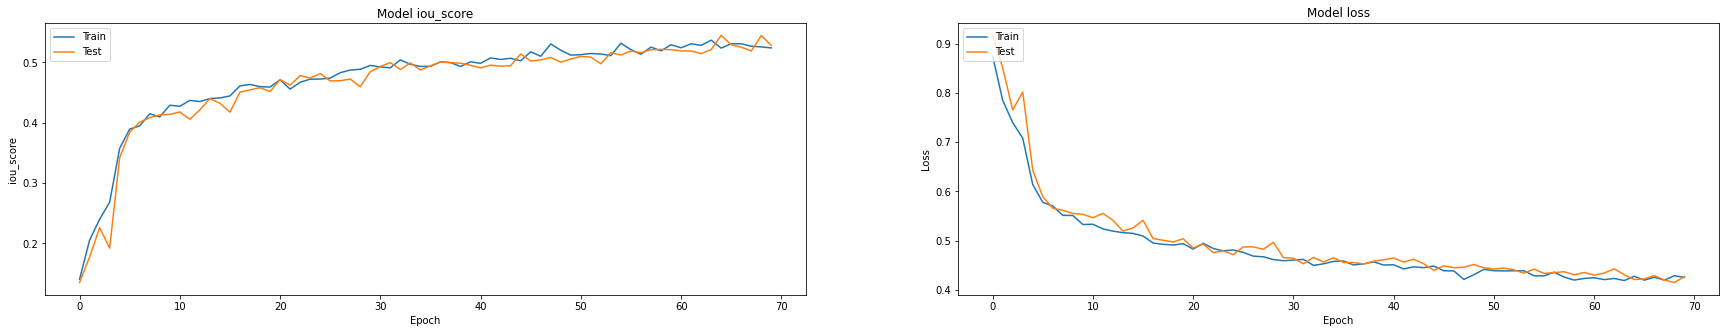

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

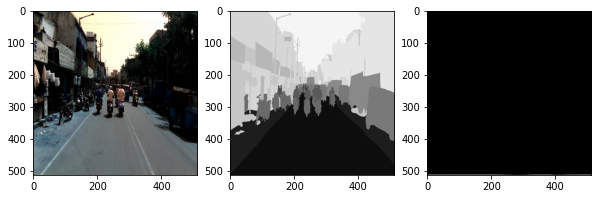

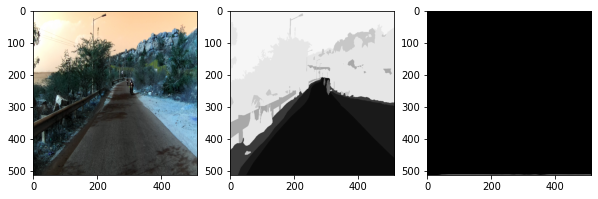

In [ ]:
a = X_test
for i in range(2):  
    #original image
    image = cv2.imread(a[i][0],cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (512, 512))
    
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])
    
    #original segmentation map
    image_mask = cv2.imread(a[i][1], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512))
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask, cmap='gray')
    plt.subplot(133)
    plt.imshow(predicted[0,:,:,0], cmap='gray')
    plt.show()

In [ ]:
dir_path = '900_images'
for p, i in enumerate(X_test):
    #original image
    image = cv2.imread(os.path.join(dir_path, i+'.jpg'), cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (512,512)) 
    
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])
    
    #original segmentation map
    image_mask = cv2.imread(os.path.join(dir_path, i+'.mask.jpg'), cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512))
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask, cmap='gray', vmax=1, vmin=0)
    plt.subplot(133)
    plt.imshow(predicted[0,:,:,0], cmap='gray', vmax=1, vmin=0)
    plt.show()

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

# Task 3: Training CANet

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [ ]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv_block"):  #, name="conv block"
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
    def call(self, X,training=True):
   
      X_parallel = X
 
      X1 = Conv2D(self.F1, kernel_size =(1, 1), strides = (self.stride,self.stride), 
                 kernel_initializer = glorot_uniform(seed=0))(X)
      X2 = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001 )(X1)
      X3 = Activation('relu')(X2)


      X4 = Conv2D(filters = self.F2, kernel_size = (self.kernel, self.kernel), strides = (1,1), padding = 'same', 
                 kernel_initializer = glorot_uniform(seed=0))(X3)
      X5 = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)(X4)
      X6 = Activation('relu')(X5)


      X7 = Conv2D(filters = self.F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
                 kernel_initializer = glorot_uniform(seed=0))(X6)
      X8 = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)(X7)



      X_parallel1 = Conv2D(filters = self.F3, kernel_size = (1, 1), strides = (self.stride,self.stride), padding = 'valid',
                        kernel_initializer = glorot_uniform(seed=0))(X_parallel)
      X_parallel2 = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)(X_parallel1)

    
      X9 = Add()([X8, X_parallel2])
      X10 = Activation('relu')(X9)
      
      return X10

In [ ]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv_block"):  #, name="conv block"
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride    

        self.Conv2d1 = Conv2D(self.F1, kernel_size =(1, 1), strides = (self.stride,self.stride), 
                 kernel_initializer = glorot_uniform(seed=0))

        self.batch1 = BatchNormalization(axis = 3)
        self.batch2 = BatchNormalization(axis = 3)
        self.batch3 = BatchNormalization(axis = 3)
        self.batch4 = BatchNormalization(axis = 3)

        self.Conv2d2 = Conv2D(filters = self.F2, kernel_size = (self.kernel, self.kernel), strides = (1,1), padding = 'same', 
                 kernel_initializer = glorot_uniform(seed=0))

        self.Conv2d3 = Conv2D(filters = self.F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
                 kernel_initializer = glorot_uniform(seed=0))

        self.Conv2d4 = Conv2D(filters = self.F3, kernel_size = (1, 1), strides = (self.stride,self.stride), padding = 'valid',
                        kernel_initializer = glorot_uniform(seed=0))                         


    def call(self, X,training=True):
   
      X_parallel = X

      X = self.Conv2d1(X)
      X = self.batch1(X)
      X = tf.nn.relu(X)


      X = self.Conv2d2(X)
      X = self.batch2(X)
      X = tf.nn.relu(X)



      X = self.Conv2d3(X)
      X = self.batch3(X)


      X_parallel = self.Conv2d4(X_parallel)
      X_parallel = self.batch4(X_parallel)

    
      X = Add()([X, X_parallel])
      X = tf.nn.relu(X)
      
      
      return X

In [ ]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
    def call(self, X,training=True):
      X_parallel = X

      X1 = Conv2D(filters = self.F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
                 kernel_initializer = glorot_uniform(seed=0))(X)
      X2 = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)(X1)
      X3 = Activation('relu')(X2)


      X4 = Conv2D(filters = self.F2, kernel_size = (self.kernel, self.kernel), strides = (1,1), padding = 'same', 
                 kernel_initializer = glorot_uniform(seed=0))(X3)
      X5 = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)(X4)
      X6 = Activation('relu')(X5)


      X7 = Conv2D(filters = self.F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
                 kernel_initializer = glorot_uniform(seed=0))(X6)
      X8 = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)(X7)


      X9 = Add()([X8, X_parallel])
      X10 = Activation('relu')(X9)
      
      return X10

In [ ]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel

        self.Conv2d1 = Conv2D(filters = self.F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
                 kernel_initializer = glorot_uniform(seed=0))
      
        self.Conv2d2 = Conv2D(filters = self.F2, kernel_size = (self.kernel, self.kernel), strides = (1,1), padding = 'same', 
                 kernel_initializer = glorot_uniform(seed=0))
      
        self.Conv2d3 = Conv2D(filters = self.F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
                 kernel_initializer = glorot_uniform(seed=0))
      
        self.batch1 = BatchNormalization(axis = 3)
        self.batch2 = BatchNormalization(axis = 3) 
        self.batch3 = BatchNormalization(axis = 3)  

    def call(self, X):
      X_parallel = X

      X = self.Conv2d1(X)
      X = self.batch1(X)
      X = tf.nn.relu(X)


      X4 = self.Conv2d2(X)
      X5 = self.batch2(X)
      X = tf.nn.relu(X)


      X = self.Conv2d3(X)
      X = self.batch3(X)


      X = Add()([X, X_parallel])
      X = tf.nn.relu(X)
      
      return X

In [ ]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.conv1 = Conv2D(filters = self.F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
                 kernel_initializer = glorot_uniform(seed=0))
        self.batch1 = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)
      
        self.conv2 = Conv2D(filters = self.F2, kernel_size = (self.kernel, self.kernel), strides = (1,1), padding = 'same', 
                 kernel_initializer = glorot_uniform(seed=0))
        self.batch2 = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)
    

        self.conv3 = Conv2D(filters = self.F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
                 kernel_initializer = glorot_uniform(seed=0))
        self.batch3 = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)


    def call(self, X,training=True):
      X_parallel = X

      X = self.conv1(X)
      X = self.batch1(X)
      X = Activation('relu')(X)


      X = self.conv2(X)
      X = self.batch2(X)
      X = Activation('relu')(X)


      X = self.conv3(X)
      X = self.batch3(X)


      X = Add()([X, X_parallel])
      X = Activation('relu')(X)
      
      return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        
    def call(self, X):
      output = X
      gf = tf.keras.layers.AveragePooling2D(strides= 1,pool_size = (16,16))(output)                  
      gf = BatchNormalization(momentum=0.99, epsilon=0.001)(gf)
      gf = Activation('relu')(gf)    
      gf = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu', padding = 'same')(gf)
      gf = (Conv2DTranspose(filters = 32 ,kernel_size = (16,16), use_bias = False))(gf)
      return gf

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        self.avg = tf.keras.layers.AveragePooling2D(strides= 1,pool_size = (16,16))                 
        self.batch = BatchNormalization() 
        self.convd1 = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu', padding = 'same')
        self.conT = (Conv2DTranspose(filters = 32 ,kernel_size = (16,16), use_bias = False))
        
    def call(self, X):
      output = X
      gf = self.avg(output)                  
      gf = self.batch(gf)
      gf = tf.nn.relu(gf)   
      gf = self.convd1(gf)
      gf = self.conT(gf)
      return gf

In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
    def call(self, X):
      # here X will a list of two elements 
      INP, FLOW = X[0], X[1] 
      Concat = Concatenate()([INP,FLOW])
      cf = AveragePooling2D((2, 2),  (2, 2), name = 'CF1_pool' )(Concat) #check
      cf_1 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(cf)
      cf_2 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(cf_1) #only two conv layer
      cf_3 = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu', padding = 'same')(cf_2)
      cf_A = Activation('relu')(cf_3)
      cf_4 = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu', padding = 'same')(cf_A)
      cf_A1 = Activation('sigmoid')(cf_4)
      cf_M = Multiply()([cf_2 , cf_A1])
      cf_add = Add()([cf_2,cf_M])
      #cf_Tr = (Conv2DTranspose(filters = 32 ,  kernel_size = (9, 9), use_bias = False ))(cf_add)
      cf_Tr  = UpSampling2D((2,2), interpolation = 'bilinear')(cf_add)


        # implement the context flow as mentioned in the above cell
      return cf_Tr

In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        
        self.avg = AveragePooling2D((2, 2),  (2, 2), name = 'cf1_pool' ) #check
        self.conv1 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')
        self.conv2 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same') #only two conv layer
        self.conv3 = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu', padding = 'same')
        self.conv4 = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu', padding = 'same')
        self.up  = UpSampling2D((2,2), interpolation = 'bilinear')

    def call(self, X):
      # here X will a list of two elements 
      INP, FLOW = X[0], X[1] 
      Concat = Concatenate()([INP,FLOW])
      cf = self.avg(Concat) #check
      cf_1 = self.conv1(cf)
      cf_2 = self.conv2(cf_1) #only two conv layer
      cf_3 = self.conv3(cf_2)
      cf_A = Activation('relu')(cf_3)
      cf_4 = self.conv4(cf_A)
      cf_A1 = Activation('sigmoid')(cf_4)
      cf_M = Multiply()([cf_2 , cf_A1])
      cf_add = Add()([cf_2,cf_M])
      #cf_Tr = (Conv2DTranspose(filters = 32 ,  kernel_size = (9, 9), use_bias = False ))(cf_add)
      cf_Tr  = self.up(cf_add)


        # implement the context flow as mentioned in the above cell
      return cf_Tr

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [ ]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        
    def call(self, X):
      FSM_1 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(X)
      FSM_avg = AveragePooling2D(1,(2, 2))(FSM_1) #check
      FSM = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu', padding = 'same')(FSM_avg)
      FSM_bn = BatchNormalization()(FSM)
      FSM_s = Activation('sigmoid')(FSM_bn)
      #FSM_M = Multiply()([FSM_1,FSM_s])
      #FSM_T = Conv2DTranspose(filters = 32 ,  kernel_size = (9, 9), use_bias = False )(FSM_s)
      FSM_T  = UpSampling2D((2,2), interpolation = 'bilinear')(FSM_s)
      FSM_T = Multiply()([FSM_1,FSM_T])
      
      # implement the FSM modules based on image in the above cells
      return FSM_T

In [ ]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')
        self.avg = AveragePooling2D(1,(2, 2)) #check
        self.conv2 = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu', padding = 'same')
        self.batch = BatchNormalization()
        self.up  = UpSampling2D((2,2), interpolation = 'bilinear')
        
    def call(self, X,training=True):
      FSM_1 = self.conv1(X)
      FSM_avg = self.avg(FSM_1) #check
      FSM = self.conv2(FSM_avg)
      FSM_bn = self.batch(FSM)
      FSM_s = Activation('sigmoid')(FSM_bn)
      #FSM_M = Multiply()([FSM_1,FSM_s])
      #FSM_T = Conv2DTranspose(filters = 32 ,  kernel_size = (9, 9), use_bias = False )(FSM_s)
      FSM_T  = self.up(FSM_s)
      FSM_T = Multiply()([FSM_1,FSM_T])
      
      # implement the FSM modules based on image in the above cells
      return FSM_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [ ]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        
    def call(self, X,training=True):
      fsm, X_Stage_2_ = X[0], X[1]

      fsm =  (UpSampling2D((2,2), interpolation='bilinear'))(fsm)

      ag_L1 = Conv2D(filters = 32, kernel_size = (7, 1), activation = 'relu', padding = 'same')(X_Stage_2_)
      ag_L2 = Conv2D(filters = 32, kernel_size = (1, 7), activation = 'relu', padding = 'same')(ag_L1)

      ag_L3 = Conv2D(filters = 32, kernel_size = (1, 7), activation = 'relu', padding = 'same')(X_Stage_2_)
      ag_L4 = Conv2D(filters = 32, kernel_size = (7, 1), activation = 'relu', padding = 'same')(ag_L3)

      sum1 = Add()([ag_L2,ag_L4])

      ag_conv = Conv2D(filters = 32, kernel_size =(3, 3), activation = 'relu', padding = 'same')(sum1)

      sum2 = Add()([sum1,ag_conv])


      
      sum2 = (UpSampling2D((2,2), interpolation='bilinear'))(sum2)
      CF = concatenate([fsm,sum2])
      X = Conv2D(filters = 40, kernel_size = (3, 3), activation = 'relu', padding = 'same')(CF)
    
      X  = UpSampling2D((4,4), interpolation = 'bilinear')(X)
      X = (Activation('softmax'))(X)
        # please implement the above mentioned architecture
      return X

In [ ]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.up =  UpSampling2D((2,2), interpolation='bilinear')
        self.conv1 = Conv2D(filters = 32, kernel_size = (7, 1), activation = 'relu', padding = 'same')
        self.conv2 = Conv2D(filters = 32, kernel_size = (1, 7), activation = 'relu', padding = 'same')

        self.conv3 = Conv2D(filters = 32, kernel_size = (1, 7), activation = 'relu', padding = 'same')
        self.conv4 = Conv2D(filters = 32, kernel_size = (7, 1), activation = 'relu', padding = 'same')

        self.conv5 = Conv2D(filters = 32, kernel_size =(3, 3), activation = 'relu', padding = 'same')
        self.up1 = UpSampling2D((2,2), interpolation='bilinear')
   
        self.conv6 = Conv2D(filters = 40, kernel_size = (3, 3), activation = 'relu', padding = 'same')
    
        self.up2  = UpSampling2D((4,4), interpolation = 'bilinear')
        
        
    def call(self, X,training=True):
      fsm, X_Stage_2_ = X[0], X[1]

      fsm =  self.up(fsm)

      ag_L1 = self.conv1(X_Stage_2_)
      ag_L2 = self.conv2(ag_L1)

      ag_L3 = self.conv3(X_Stage_2_)
      ag_L4 = self.conv4(ag_L3)

      sum1 = Add()([ag_L2,ag_L4])

      ag_conv = self.conv5(sum1)

      sum2 = Add()([sum1,ag_conv])


      
      sum2 = self.up1(sum2)
      CF = concatenate([fsm,sum2])
      X = self.conv6(CF)
    
      X  = self.up2(X)
      X = (Activation('softmax'))(X)
        # please implement the above mentioned architecture
      return X

In [ ]:
X_input = Input(shape=(512,512,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)


print(X.shape)

(None, 256, 256, 64)


In [ ]:
# Stage 2
convol1 = convolutional_block(kernel=3, filters=[4, 4, 8], stride=4,name = 'block_conv1' )
identity1 = identity_block( kernel = 3, filters = [4, 4, 8],name = 'identity1')
X_Stage_2_ = convol1(X)
X_Stage_2 = identity1(X_Stage_2_)
X_Stage_2 = identity1(X_Stage_2)


# Stage 3 
convol2 = convolutional_block(kernel=3, filters=[8, 8, 16], stride=1,name = 'block_conv2')
identity2 = identity_block( kernel = 3, filters = [8, 8, 16],name = 'identity2')
X_Stage_3 = convol2(X_Stage_2)
X_Stage_3 = identity2(X_Stage_3)
X_Stage_3 = identity2(X_Stage_3)
X_Stage_3 = identity2(X_Stage_3)

# Stage 4 
convol3 = convolutional_block(kernel=3, filters=[16, 16, 32], stride=1,name = 'block_conv3')
identity3 = identity_block( kernel = 3, filters = [16, 16, 32],name = 'identity3')
X_Stage_4 = convol3(X_Stage_3)
X_Stage_4 = identity3(X_Stage_4)
X_Stage_4 = identity3(X_Stage_4)
X_Stage_4 = identity3(X_Stage_4)
X_Stage_4 = identity3(X_Stage_4)
X_Stage_4 = identity3(X_Stage_4)

# Stage 5 
convol4 = convolutional_block(kernel=3, filters=[32, 32, 64], stride=1,name = 'block_conv4')
identity4 = identity_block( kernel = 3, filters = [32, 32, 64],name = 'identity4')
X_Stage_5 = convol4(X_Stage_4)
X_Stage_5 = identity4(X_Stage_5)
X_Stage_5 = identity4(X_Stage_5)

#global flow
glo = global_flow()
gf = glo(X_Stage_5)

#Context flow
context = context_flow()

X1 = [X_Stage_5,gf]
cf_1 = context(X1)

X1 = [X_Stage_5,cf_1]
cf_2 = context(X1)

X1 = [X_Stage_5,cf_2]
cf_3 = context(X1)

#adding 
sum = Add(name = 'add')([gf, cf_1, cf_2, cf_3])

#feature selection module
feature = fsm()
FSM_T = feature(sum)


#Adapted Global Convolutional Network
Adapted = agcn()
X2 = [FSM_T, X_Stage_2_]

output = Adapted(X2)

model = Model(inputs = X_input, outputs = output)

for layer in model.layers:
  layer.trainable = True 

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           bn_conv1[0][0]                   
____________________________________________________________________________________________

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [ ]:
# https://github.com/qubvel/segmentation_models
#import segmentation_models as sm
from segmentation_models.metrics import iou_score
#from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.0001)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2),
]

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=5,\
                              validation_data=test_dataloader,validation_steps =len(test_dataloader),callbacks=callbacks, )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/5
2680/2680 [==============================] - 5331s 2s/step - loss: 1.0377 - iou_score: 0.0455 - val_loss: 1.1010 - val_iou_score: 0.0401
Epoch 2/5
2680/2680 [==============================] - 3291s 1s/step - loss: 0.9911 - iou_score: 0.0677 - val_loss: 1.0803 - val_iou_score: 0.0454
Epoch 3/5
2680/2680 [==============================] - 3118s 1s/step - loss: 0.9796 - iou_score: 0.0733 - val_loss: 1.0848 - val_iou_score: 0.0452
Epoch 4/5
2680/2680 [==============================] - 3044s 1s/step - loss: 0.9708 - iou_score: 0.0780 - val_loss: 1.0883 - val_iou_score: 0.0440
Epoch 5/5
2680/2680 [==============================] - 3013s 1s/step - loss: 0.9706 - iou_score: 0.0789 - val_loss: 1.0919 - val_iou_score: 0.0451


In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations